In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json

In [2]:
with open(r"data/ATE_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/ATE_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/ATE_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [4]:
def convert_data_to_tensors(data, word_vectors):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
            if word in word_vectors:
                embedding.append(word_vectors[word])
            else:
                embedding.append([0] * len(word_vectors['hello']))  # Use a zero vector for unknown words
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len = 83 # maximum length of word in 1 text 
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * len(word_vectors['hello'])] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    input_ids = torch.tensor(padded_embeddings)

    return input_ids

In [5]:

x_train = convert_data_to_tensors(train_data, word_vectors)
x_val = convert_data_to_tensors(val_data, word_vectors)
x_test = convert_data_to_tensors(test_data, word_vectors)

/tmp/ipykernel_30851/3668873182.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings)


In [6]:
x_train.size()

torch.Size([906, 83, 300])

In [7]:
def convert_labels_to_fixed_length(labels, max_length):
    new_list=[]
    label_to_index = {'B': 0, 'I': 1, 'O': 2,'<pad>':3}
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 3
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 83
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [8]:
len(length_val)

219

In [9]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [10]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class RNNTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNTagger, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 4
learning_rate = 0.001
num_epochs = 150
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = RNNTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_30851/2469601546.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_30851/2469601546.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_30851/2469601546.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_30851/2469601546.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Epoch 1/150, Train Loss: 1.139032669365406, Val Loss: 0.6228537559509277, Val F1: 0.3175645342312009, Train F1: 0.21588801277605452


  1%|█▉                                                                                                                                                | 2/150 [00:01<02:16,  1.08it/s]

Epoch 2/150, Train Loss: 0.5481697879731655, Val Loss: 0.4601008892059326, Val F1: 0.31987831333468913, Train F1: 0.30360269315739036


  2%|██▉                                                                                                                                               | 3/150 [00:02<02:07,  1.15it/s]

Epoch 3/150, Train Loss: 0.4493445083498955, Val Loss: 0.37946373224258423, Val F1: 0.32643592849493414, Train F1: 0.3271977132266338


  3%|███▉                                                                                                                                              | 4/150 [00:03<02:04,  1.18it/s]

Epoch 4/150, Train Loss: 0.3938700556755066, Val Loss: 0.36241990327835083, Val F1: 0.3631556686060677, Train F1: 0.3455469559781253


  3%|████▊                                                                                                                                             | 5/150 [00:03<01:44,  1.38it/s]

Epoch 5/150, Train Loss: 0.36298317462205887, Val Loss: 0.33152276277542114, Val F1: 0.3631556686060677, Train F1: 0.34835928062045496


  4%|█████▊                                                                                                                                            | 6/150 [00:04<01:36,  1.49it/s]

Epoch 6/150, Train Loss: 0.3395017236471176, Val Loss: 0.3041766285896301, Val F1: 0.4004507710557532, Train F1: 0.3631328008446422


  5%|██████▊                                                                                                                                           | 7/150 [00:05<01:30,  1.58it/s]

Epoch 7/150, Train Loss: 0.3213124983012676, Val Loss: 0.2839076519012451, Val F1: 0.44669662036431834, Train F1: 0.40760085346483477


  5%|███████▊                                                                                                                                          | 8/150 [00:05<01:24,  1.68it/s]

Epoch 8/150, Train Loss: 0.2878203596919775, Val Loss: 0.26285427808761597, Val F1: 0.4559575614645102, Train F1: 0.4483388972876551


  6%|████████▊                                                                                                                                         | 9/150 [00:06<01:21,  1.74it/s]

Epoch 9/150, Train Loss: 0.2669199500232935, Val Loss: 0.24801933765411377, Val F1: 0.5320768747101637, Train F1: 0.487233118264977


  7%|█████████▋                                                                                                                                       | 10/150 [00:06<01:31,  1.53it/s]

Epoch 10/150, Train Loss: 0.26985663175582886, Val Loss: 0.23531150817871094, Val F1: 0.5822257283286234, Train F1: 0.5062768342507443


  7%|██████████▋                                                                                                                                      | 11/150 [00:07<01:23,  1.67it/s]

Epoch 11/150, Train Loss: 0.2561245709657669, Val Loss: 0.22383007407188416, Val F1: 0.5850594571231621, Train F1: 0.5631501795995185


  8%|███████████▌                                                                                                                                     | 12/150 [00:07<01:19,  1.73it/s]

Epoch 12/150, Train Loss: 0.23380282521247864, Val Loss: 0.2145732194185257, Val F1: 0.5992673519174448, Train F1: 0.5980745356302241


  9%|████████████▌                                                                                                                                    | 13/150 [00:08<01:15,  1.81it/s]

Epoch 13/150, Train Loss: 0.22770428657531738, Val Loss: 0.20862866938114166, Val F1: 0.6810630104348271, Train F1: 0.6092397098505425


  9%|█████████████▌                                                                                                                                   | 14/150 [00:09<01:17,  1.75it/s]

Epoch 14/150, Train Loss: 0.21475127898156643, Val Loss: 0.20043790340423584, Val F1: 0.6684136562223101, Train F1: 0.669698453684552


 10%|██████████████▌                                                                                                                                  | 15/150 [00:09<01:15,  1.78it/s]

Epoch 15/150, Train Loss: 0.21992772072553635, Val Loss: 0.19422252476215363, Val F1: 0.7047556643276813, Train F1: 0.6635237138708394


 11%|███████████████▍                                                                                                                                 | 16/150 [00:10<01:14,  1.79it/s]

Epoch 16/150, Train Loss: 0.21301231905817986, Val Loss: 0.18891295790672302, Val F1: 0.71582289617547, Train F1: 0.7049806679418558


 11%|████████████████▍                                                                                                                                | 17/150 [00:10<01:14,  1.79it/s]

Epoch 17/150, Train Loss: 0.18940070644021034, Val Loss: 0.1909443438053131, Val F1: 0.6435932038568785, Train F1: 0.7294432900244299


 12%|█████████████████▍                                                                                                                               | 18/150 [00:11<01:15,  1.75it/s]

Epoch 18/150, Train Loss: 0.21133114583790302, Val Loss: 0.18871986865997314, Val F1: 0.7442748957676303, Train F1: 0.7012211038939323


 13%|██████████████████▎                                                                                                                              | 19/150 [00:11<01:17,  1.69it/s]

Epoch 19/150, Train Loss: 0.18595576658844948, Val Loss: 0.17944307625293732, Val F1: 0.7128066459120951, Train F1: 0.7119010400848161


 13%|███████████████████▎                                                                                                                             | 20/150 [00:12<01:16,  1.71it/s]

Epoch 20/150, Train Loss: 0.20750435441732407, Val Loss: 0.17951330542564392, Val F1: 0.7509154487310546, Train F1: 0.7295719629431879


 14%|████████████████████▎                                                                                                                            | 21/150 [00:13<01:16,  1.69it/s]

Epoch 21/150, Train Loss: 0.17955939285457134, Val Loss: 0.1776997298002243, Val F1: 0.6955115531989368, Train F1: 0.7476113687306064


 15%|█████████████████████▎                                                                                                                           | 22/150 [00:13<01:12,  1.77it/s]

Epoch 22/150, Train Loss: 0.17441466823220253, Val Loss: 0.17618754506111145, Val F1: 0.69549658655455, Train F1: 0.7612274370628269


 15%|██████████████████████▏                                                                                                                          | 23/150 [00:14<01:11,  1.78it/s]

Epoch 23/150, Train Loss: 0.17648830264806747, Val Loss: 0.17213639616966248, Val F1: 0.7534423289882176, Train F1: 0.7577016827654823


 16%|███████████████████████▏                                                                                                                         | 24/150 [00:14<01:08,  1.84it/s]

Epoch 24/150, Train Loss: 0.16879158467054367, Val Loss: 0.171009361743927, Val F1: 0.7560774067701016, Train F1: 0.7765165519944107


 17%|████████████████████████▏                                                                                                                        | 25/150 [00:15<01:14,  1.68it/s]

Epoch 25/150, Train Loss: 0.157471826300025, Val Loss: 0.1709820032119751, Val F1: 0.7289322066759679, Train F1: 0.7716274647884017


 17%|█████████████████████████▏                                                                                                                       | 26/150 [00:16<01:15,  1.64it/s]

Epoch 26/150, Train Loss: 0.15614029113203287, Val Loss: 0.1678793877363205, Val F1: 0.7443607826885987, Train F1: 0.7748339574397831


 18%|██████████████████████████                                                                                                                       | 27/150 [00:16<01:12,  1.71it/s]

Epoch 27/150, Train Loss: 0.15417733415961266, Val Loss: 0.16887767612934113, Val F1: 0.7583715072952154, Train F1: 0.7803909350275554


 19%|███████████████████████████                                                                                                                      | 28/150 [00:17<01:14,  1.63it/s]

Epoch 28/150, Train Loss: 0.1489916555583477, Val Loss: 0.16844655573368073, Val F1: 0.7651649471292088, Train F1: 0.8009189865231066


 19%|████████████████████████████                                                                                                                     | 29/150 [00:18<01:21,  1.48it/s]

Epoch 29/150, Train Loss: 0.15216227434575558, Val Loss: 0.16604536771774292, Val F1: 0.7408964472665739, Train F1: 0.7949861220787667


 20%|█████████████████████████████                                                                                                                    | 30/150 [00:18<01:22,  1.46it/s]

Epoch 30/150, Train Loss: 0.1476314701139927, Val Loss: 0.16544316709041595, Val F1: 0.7536043860135432, Train F1: 0.7957397207921643


 21%|█████████████████████████████▉                                                                                                                   | 31/150 [00:19<01:19,  1.51it/s]

Epoch 31/150, Train Loss: 0.1515143569558859, Val Loss: 0.16585518419742584, Val F1: 0.738089767316784, Train F1: 0.8042016831784302


 21%|██████████████████████████████▉                                                                                                                  | 32/150 [00:19<01:12,  1.62it/s]

Epoch 32/150, Train Loss: 0.1416308544576168, Val Loss: 0.1689140647649765, Val F1: 0.7288763122841809, Train F1: 0.7776546910946004


 22%|███████████████████████████████▉                                                                                                                 | 33/150 [00:20<01:16,  1.53it/s]

Epoch 33/150, Train Loss: 0.1371756363660097, Val Loss: 0.16424337029457092, Val F1: 0.751884268624092, Train F1: 0.8082515421783133


 23%|████████████████████████████████▊                                                                                                                | 34/150 [00:21<01:18,  1.49it/s]

Epoch 34/150, Train Loss: 0.1335303271189332, Val Loss: 0.16464103758335114, Val F1: 0.7458798241226612, Train F1: 0.8197783356308629


 23%|█████████████████████████████████▊                                                                                                               | 35/150 [00:22<01:17,  1.47it/s]

Epoch 35/150, Train Loss: 0.13901945110410452, Val Loss: 0.17345283925533295, Val F1: 0.7231311400927808, Train F1: 0.7808235906943417


 24%|██████████████████████████████████▊                                                                                                              | 36/150 [00:22<01:13,  1.55it/s]

Epoch 36/150, Train Loss: 0.13566327653825283, Val Loss: 0.167636901140213, Val F1: 0.7507303940196319, Train F1: 0.8147103006613937


 25%|███████████████████████████████████▊                                                                                                             | 37/150 [00:23<01:10,  1.60it/s]

Epoch 37/150, Train Loss: 0.13150186371058226, Val Loss: 0.16514118015766144, Val F1: 0.757449399584806, Train F1: 0.8291174919746769


 25%|████████████████████████████████████▋                                                                                                            | 38/150 [00:23<01:10,  1.60it/s]

Epoch 38/150, Train Loss: 0.12897774949669838, Val Loss: 0.16535918414592743, Val F1: 0.7633098479978407, Train F1: 0.8315662970968616


 26%|█████████████████████████████████████▋                                                                                                           | 39/150 [00:24<01:08,  1.63it/s]

Epoch 39/150, Train Loss: 0.12476716842502356, Val Loss: 0.168305441737175, Val F1: 0.74650939805794, Train F1: 0.8456793052601894


 27%|██████████████████████████████████████▋                                                                                                          | 40/150 [00:25<01:11,  1.54it/s]

Epoch 40/150, Train Loss: 0.11952176876366138, Val Loss: 0.1707126349210739, Val F1: 0.7445646015788601, Train F1: 0.837967555247602


 27%|███████████████████████████████████████▋                                                                                                         | 41/150 [00:25<01:08,  1.58it/s]

Epoch 41/150, Train Loss: 0.12075607012957335, Val Loss: 0.17436815798282623, Val F1: 0.7291688426105741, Train F1: 0.8269393106525977


 28%|████████████████████████████████████████▌                                                                                                        | 42/150 [00:26<01:03,  1.70it/s]

Epoch 42/150, Train Loss: 0.11827756091952324, Val Loss: 0.16845643520355225, Val F1: 0.7459707689628682, Train F1: 0.8403574089523148


 29%|█████████████████████████████████████████▌                                                                                                       | 43/150 [00:26<01:01,  1.75it/s]

Epoch 43/150, Train Loss: 0.11859019845724106, Val Loss: 0.166734516620636, Val F1: 0.7625904181499178, Train F1: 0.8511329213634675


 29%|██████████████████████████████████████████▌                                                                                                      | 44/150 [00:27<01:03,  1.67it/s]

Epoch 44/150, Train Loss: 0.11542314477264881, Val Loss: 0.17210984230041504, Val F1: 0.7448816599224976, Train F1: 0.8527755468687143


 30%|███████████████████████████████████████████▌                                                                                                     | 45/150 [00:28<01:04,  1.62it/s]

Epoch 45/150, Train Loss: 0.10958272404968739, Val Loss: 0.1731756180524826, Val F1: 0.7267384929189825, Train F1: 0.8633178610669351


 31%|████████████████████████████████████████████▍                                                                                                    | 46/150 [00:28<01:10,  1.48it/s]

Epoch 46/150, Train Loss: 0.12428497523069382, Val Loss: 0.17064356803894043, Val F1: 0.7542522623032012, Train F1: 0.8482820273289249


 31%|█████████████████████████████████████████████▍                                                                                                   | 47/150 [00:29<01:18,  1.30it/s]

Epoch 47/150, Train Loss: 0.11738703772425652, Val Loss: 0.1729462742805481, Val F1: 0.7605953655258326, Train F1: 0.8572934362223718


 32%|██████████████████████████████████████████████▍                                                                                                  | 48/150 [00:30<01:11,  1.43it/s]

Epoch 48/150, Train Loss: 0.1025017537176609, Val Loss: 0.1728881448507309, Val F1: 0.7496613011825497, Train F1: 0.8716214924806234


 33%|███████████████████████████████████████████████▎                                                                                                 | 49/150 [00:31<01:07,  1.49it/s]

Epoch 49/150, Train Loss: 0.1079229936003685, Val Loss: 0.17891113460063934, Val F1: 0.7729013749632769, Train F1: 0.8646072664670514


 33%|████████████████████████████████████████████████▎                                                                                                | 50/150 [00:31<01:11,  1.39it/s]

Epoch 50/150, Train Loss: 0.10767121985554695, Val Loss: 0.18537160754203796, Val F1: 0.7669217077038722, Train F1: 0.8593386036952866


 34%|█████████████████████████████████████████████████▎                                                                                               | 51/150 [00:32<01:15,  1.31it/s]

Epoch 51/150, Train Loss: 0.10214618686586618, Val Loss: 0.1699686050415039, Val F1: 0.7543779348730529, Train F1: 0.8684609771188814


 35%|██████████████████████████████████████████████████▎                                                                                              | 52/150 [00:33<01:11,  1.37it/s]

Epoch 52/150, Train Loss: 0.0919462637975812, Val Loss: 0.17275269329547882, Val F1: 0.7489202869508534, Train F1: 0.8844627908071518


 35%|███████████████████████████████████████████████████▏                                                                                             | 53/150 [00:34<01:11,  1.36it/s]

Epoch 53/150, Train Loss: 0.09379115328192711, Val Loss: 0.17710891366004944, Val F1: 0.7734700140984493, Train F1: 0.8828536024469669


 36%|████████████████████████████████████████████████████▏                                                                                            | 54/150 [00:34<01:13,  1.31it/s]

Epoch 54/150, Train Loss: 0.09137180726975203, Val Loss: 0.18143436312675476, Val F1: 0.7759280662039997, Train F1: 0.8938342790298721


 37%|█████████████████████████████████████████████████████▏                                                                                           | 55/150 [00:35<01:13,  1.30it/s]

Epoch 55/150, Train Loss: 0.08976502437144518, Val Loss: 0.17754177749156952, Val F1: 0.7628303801476665, Train F1: 0.8961451983311582


 37%|██████████████████████████████████████████████████████▏                                                                                          | 56/150 [00:36<01:09,  1.36it/s]

Epoch 56/150, Train Loss: 0.08601418044418097, Val Loss: 0.18310384452342987, Val F1: 0.742220415982498, Train F1: 0.8950198016518678


 38%|███████████████████████████████████████████████████████                                                                                          | 57/150 [00:37<01:06,  1.40it/s]

Epoch 57/150, Train Loss: 0.0875317845493555, Val Loss: 0.1825806200504303, Val F1: 0.7444178495359836, Train F1: 0.8852761956212607


 39%|████████████████████████████████████████████████████████                                                                                         | 58/150 [00:37<01:03,  1.44it/s]

Epoch 58/150, Train Loss: 0.08062058128416538, Val Loss: 0.19245769083499908, Val F1: 0.7386848250363863, Train F1: 0.9083027379063323


 39%|█████████████████████████████████████████████████████████                                                                                        | 59/150 [00:38<01:05,  1.39it/s]

Epoch 59/150, Train Loss: 0.08313558157533407, Val Loss: 0.18640004098415375, Val F1: 0.7387948668331948, Train F1: 0.891584808941747


 40%|██████████████████████████████████████████████████████████                                                                                       | 60/150 [00:39<01:06,  1.36it/s]

Epoch 60/150, Train Loss: 0.07779253087937832, Val Loss: 0.19078555703163147, Val F1: 0.7696327490902775, Train F1: 0.9118004112353709


 41%|██████████████████████████████████████████████████████████▉                                                                                      | 61/150 [00:40<01:05,  1.37it/s]

Epoch 61/150, Train Loss: 0.07709596212953329, Val Loss: 0.1889784336090088, Val F1: 0.7645636933042784, Train F1: 0.9202085558145001


 41%|███████████████████████████████████████████████████████████▉                                                                                     | 62/150 [00:40<01:01,  1.44it/s]

Epoch 62/150, Train Loss: 0.07685874402523041, Val Loss: 0.18485243618488312, Val F1: 0.7587375911979132, Train F1: 0.9105556393805905


 42%|████████████████████████████████████████████████████████████▉                                                                                    | 63/150 [00:41<01:01,  1.42it/s]

Epoch 63/150, Train Loss: 0.07167103560641408, Val Loss: 0.19260412454605103, Val F1: 0.7360741417618629, Train F1: 0.922318802861591


 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 64/150 [00:42<00:59,  1.45it/s]

Epoch 64/150, Train Loss: 0.0679804845713079, Val Loss: 0.20709067583084106, Val F1: 0.7191793894590823, Train F1: 0.9268976547094872


 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 65/150 [00:42<00:56,  1.51it/s]

Epoch 65/150, Train Loss: 0.06769008049741387, Val Loss: 0.20188044011592865, Val F1: 0.7200610793208481, Train F1: 0.9305057621883629


 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 66/150 [00:43<00:52,  1.61it/s]

Epoch 66/150, Train Loss: 0.0637233448214829, Val Loss: 0.19834087789058685, Val F1: 0.7454530206279918, Train F1: 0.9250122031158646


 45%|████████████████████████████████████████████████████████████████▊                                                                                | 67/150 [00:43<00:53,  1.55it/s]

Epoch 67/150, Train Loss: 0.06591255264356732, Val Loss: 0.2003231793642044, Val F1: 0.7370583275260016, Train F1: 0.9264171147794258


 45%|█████████████████████████████████████████████████████████████████▋                                                                               | 68/150 [00:44<00:50,  1.61it/s]

Epoch 68/150, Train Loss: 0.06888990942388773, Val Loss: 0.21033057570457458, Val F1: 0.7160475366352665, Train F1: 0.932319819313918


 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 69/150 [00:44<00:48,  1.66it/s]

Epoch 69/150, Train Loss: 0.0723197003826499, Val Loss: 0.2081141471862793, Val F1: 0.7350562257022011, Train F1: 0.9071261423136188


 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 70/150 [00:45<00:48,  1.64it/s]

Epoch 70/150, Train Loss: 0.06795122334733605, Val Loss: 0.2085437774658203, Val F1: 0.7392159987749981, Train F1: 0.8855500818941648


 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 71/150 [00:46<00:45,  1.75it/s]

Epoch 71/150, Train Loss: 0.06628760090097785, Val Loss: 0.2006680816411972, Val F1: 0.7391293365453322, Train F1: 0.9280935644078574


 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 72/150 [00:46<00:47,  1.64it/s]

Epoch 72/150, Train Loss: 0.05862888228148222, Val Loss: 0.20797911286354065, Val F1: 0.7368220861456201, Train F1: 0.9439053239047246


 49%|██████████████████████████████████████████████████████████████████████▌                                                                          | 73/150 [00:47<00:48,  1.60it/s]

Epoch 73/150, Train Loss: 0.06153069017454982, Val Loss: 0.2113109678030014, Val F1: 0.7421769092535161, Train F1: 0.9365682702430457


 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 74/150 [00:48<00:46,  1.63it/s]

Epoch 74/150, Train Loss: 0.059389305766671896, Val Loss: 0.20940904319286346, Val F1: 0.7312468697839595, Train F1: 0.9240995523787355


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 75/150 [00:48<00:46,  1.62it/s]

Epoch 75/150, Train Loss: 0.0575537676922977, Val Loss: 0.2146020531654358, Val F1: 0.7431790842079912, Train F1: 0.939642493362342


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 76/150 [00:49<00:48,  1.53it/s]

Epoch 76/150, Train Loss: 0.05646277079358697, Val Loss: 0.2077128142118454, Val F1: 0.742777532727995, Train F1: 0.9393958953876409


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                      | 77/150 [00:50<00:48,  1.51it/s]

Epoch 77/150, Train Loss: 0.052586355712264776, Val Loss: 0.21906638145446777, Val F1: 0.749829295042399, Train F1: 0.9521316921019946


 52%|███████████████████████████████████████████████████████████████████████████▍                                                                     | 78/150 [00:50<00:44,  1.60it/s]

Epoch 78/150, Train Loss: 0.048448697198182344, Val Loss: 0.21445930004119873, Val F1: 0.7480635565625503, Train F1: 0.9534720553215514


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 79/150 [00:51<00:42,  1.66it/s]

Epoch 79/150, Train Loss: 0.04914382752031088, Val Loss: 0.21912670135498047, Val F1: 0.7460651990644832, Train F1: 0.9518762528123237


 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 80/150 [00:51<00:43,  1.59it/s]

Epoch 80/150, Train Loss: 0.04539061291143298, Val Loss: 0.2155786156654358, Val F1: 0.7550295812350735, Train F1: 0.9616553860288225


 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 81/150 [00:52<00:45,  1.53it/s]

Epoch 81/150, Train Loss: 0.04386623576283455, Val Loss: 0.22024723887443542, Val F1: 0.7637426396641872, Train F1: 0.9601853192330965


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                 | 82/150 [00:53<00:47,  1.42it/s]

Epoch 82/150, Train Loss: 0.03976465482264757, Val Loss: 0.22222615778446198, Val F1: 0.7565678112301498, Train F1: 0.9680586298404248


 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                | 83/150 [00:53<00:41,  1.60it/s]

Epoch 83/150, Train Loss: 0.03973493538796902, Val Loss: 0.22418329119682312, Val F1: 0.7575093807237919, Train F1: 0.9676571909622771


 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                               | 84/150 [00:54<00:37,  1.75it/s]

Epoch 84/150, Train Loss: 0.03787246230058372, Val Loss: 0.2391097992658615, Val F1: 0.7316772213643454, Train F1: 0.9711905988311286


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 85/150 [00:54<00:36,  1.76it/s]

Epoch 85/150, Train Loss: 0.043514263816177845, Val Loss: 0.23434901237487793, Val F1: 0.7494194406501773, Train F1: 0.9235099497962638


 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                             | 86/150 [00:55<00:34,  1.87it/s]

Epoch 86/150, Train Loss: 0.04455187590792775, Val Loss: 0.23817941546440125, Val F1: 0.750304581577056, Train F1: 0.9621078127514956


 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 87/150 [00:55<00:32,  1.97it/s]

Epoch 87/150, Train Loss: 0.03767768945544958, Val Loss: 0.23112766444683075, Val F1: 0.7465578115753176, Train F1: 0.9691622681675462


 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 88/150 [00:56<00:32,  1.92it/s]

Epoch 88/150, Train Loss: 0.03625607071444392, Val Loss: 0.23428019881248474, Val F1: 0.7485265593375449, Train F1: 0.9700351369936117


 59%|██████████████████████████████████████████████████████████████████████████████████████                                                           | 89/150 [00:56<00:31,  1.92it/s]

Epoch 89/150, Train Loss: 0.03434030618518591, Val Loss: 0.23127838969230652, Val F1: 0.7377339739840973, Train F1: 0.9701064131271984


 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 90/150 [00:57<00:31,  1.89it/s]

Epoch 90/150, Train Loss: 0.032320833997800946, Val Loss: 0.23689788579940796, Val F1: 0.731764806408249, Train F1: 0.9758570547637431


 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                         | 91/150 [00:57<00:30,  1.94it/s]

Epoch 91/150, Train Loss: 0.030656311893835664, Val Loss: 0.23441095650196075, Val F1: 0.7442633037483444, Train F1: 0.9792149403442001


 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 92/150 [00:58<00:29,  1.98it/s]

Epoch 92/150, Train Loss: 0.029699551640078425, Val Loss: 0.24338607490062714, Val F1: 0.7404266341429517, Train F1: 0.9786301890843395


 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 93/150 [00:58<00:28,  1.98it/s]

Epoch 93/150, Train Loss: 0.030099080177024007, Val Loss: 0.24883703887462616, Val F1: 0.7486072578951836, Train F1: 0.9785891272741951


 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 94/150 [00:59<00:32,  1.74it/s]

Epoch 94/150, Train Loss: 0.029549563769251108, Val Loss: 0.25384658575057983, Val F1: 0.7249766866007512, Train F1: 0.983164559458435


 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 95/150 [01:00<00:31,  1.76it/s]

Epoch 95/150, Train Loss: 0.031157970428466797, Val Loss: 0.24711258709430695, Val F1: 0.7506668990185519, Train F1: 0.9762959580006147


 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 96/150 [01:00<00:32,  1.68it/s]

Epoch 96/150, Train Loss: 0.034137169597670436, Val Loss: 0.25982677936553955, Val F1: 0.7412030022064071, Train F1: 0.9729061956573506


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 97/150 [01:01<00:31,  1.71it/s]

Epoch 97/150, Train Loss: 0.03261939715594053, Val Loss: 0.2538911700248718, Val F1: 0.7490572013166088, Train F1: 0.9659233825969268


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 98/150 [01:01<00:31,  1.66it/s]

Epoch 98/150, Train Loss: 0.03148432751186192, Val Loss: 0.2429572194814682, Val F1: 0.7510416477567722, Train F1: 0.9740324619784015


 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 99/150 [01:02<00:29,  1.74it/s]

Epoch 99/150, Train Loss: 0.02862345683388412, Val Loss: 0.2542797327041626, Val F1: 0.7510604422908781, Train F1: 0.9746609574468852


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 100/150 [01:03<00:28,  1.76it/s]

Epoch 100/150, Train Loss: 0.025970253394916654, Val Loss: 0.25135159492492676, Val F1: 0.7390103034871668, Train F1: 0.9825947325324941


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 101/150 [01:03<00:27,  1.79it/s]

Epoch 101/150, Train Loss: 0.023534591076895595, Val Loss: 0.26066264510154724, Val F1: 0.7401129599559181, Train F1: 0.9861259320769857


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 102/150 [01:04<00:27,  1.77it/s]

Epoch 102/150, Train Loss: 0.024855958530679345, Val Loss: 0.2655225992202759, Val F1: 0.7290368119262008, Train F1: 0.9848588135704086


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 103/150 [01:04<00:26,  1.76it/s]

Epoch 103/150, Train Loss: 0.024121888913214207, Val Loss: 0.2660926580429077, Val F1: 0.7432173586666261, Train F1: 0.984074938383268


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 104/150 [01:05<00:25,  1.78it/s]

Epoch 104/150, Train Loss: 0.021118075703270733, Val Loss: 0.26130178570747375, Val F1: 0.7432253698034311, Train F1: 0.987646945664113


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 105/150 [01:05<00:24,  1.82it/s]

Epoch 105/150, Train Loss: 0.021505916491150856, Val Loss: 0.2700357437133789, Val F1: 0.7409462815997658, Train F1: 0.9874748626995843


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 106/150 [01:06<00:23,  1.84it/s]

Epoch 106/150, Train Loss: 0.020522025180980563, Val Loss: 0.2628750205039978, Val F1: 0.7471772823099831, Train F1: 0.9881007595586676


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 107/150 [01:06<00:23,  1.85it/s]

Epoch 107/150, Train Loss: 0.021220465889200568, Val Loss: 0.2765427827835083, Val F1: 0.7289761331514925, Train F1: 0.9866180259123916


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 108/150 [01:07<00:23,  1.80it/s]

Epoch 108/150, Train Loss: 0.02304736850783229, Val Loss: 0.2705843150615692, Val F1: 0.7442842298385411, Train F1: 0.9857134651135266


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 109/150 [01:07<00:21,  1.86it/s]

Epoch 109/150, Train Loss: 0.022606583079323173, Val Loss: 0.28037968277931213, Val F1: 0.7264009738142431, Train F1: 0.9835326064839803


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 110/150 [01:08<00:20,  1.94it/s]

Epoch 110/150, Train Loss: 0.020181670901365578, Val Loss: 0.28679606318473816, Val F1: 0.7393791821891629, Train F1: 0.9863799131017382


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 111/150 [01:08<00:18,  2.12it/s]

Epoch 111/150, Train Loss: 0.02092867740429938, Val Loss: 0.2680610716342926, Val F1: 0.748069035380115, Train F1: 0.9868415404079734


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 112/150 [01:09<00:16,  2.28it/s]

Epoch 112/150, Train Loss: 0.01972521119751036, Val Loss: 0.2802667021751404, Val F1: 0.728823697626623, Train F1: 0.9886044733959121


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 113/150 [01:09<00:14,  2.47it/s]

Epoch 113/150, Train Loss: 0.017874589888378978, Val Loss: 0.2787209451198578, Val F1: 0.7517966108924935, Train F1: 0.9902523340415698


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 114/150 [01:09<00:14,  2.54it/s]

Epoch 114/150, Train Loss: 0.018396297586150467, Val Loss: 0.28800326585769653, Val F1: 0.7372124876494874, Train F1: 0.989300281685598


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 115/150 [01:10<00:13,  2.67it/s]

Epoch 115/150, Train Loss: 0.019898341968655586, Val Loss: 0.28474220633506775, Val F1: 0.7382704820692063, Train F1: 0.9864458880911331


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 116/150 [01:10<00:12,  2.80it/s]

Epoch 116/150, Train Loss: 0.01769299223087728, Val Loss: 0.28571817278862, Val F1: 0.7426046728997117, Train F1: 0.9897842900686556


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 117/150 [01:10<00:11,  2.91it/s]

Epoch 117/150, Train Loss: 0.016126032802276313, Val Loss: 0.2827102243900299, Val F1: 0.7402374493857377, Train F1: 0.9909229759732844


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 118/150 [01:11<00:11,  2.90it/s]

Epoch 118/150, Train Loss: 0.015859842766076326, Val Loss: 0.2937537729740143, Val F1: 0.7408964468248861, Train F1: 0.9910974303674401


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 119/150 [01:11<00:10,  2.96it/s]

Epoch 119/150, Train Loss: 0.015743316616863012, Val Loss: 0.2928828001022339, Val F1: 0.7385617250823723, Train F1: 0.9911587346238688


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 120/150 [01:11<00:10,  2.85it/s]

Epoch 120/150, Train Loss: 0.0163900243351236, Val Loss: 0.29460301995277405, Val F1: 0.7331738834916283, Train F1: 0.9906598105768055


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 121/150 [01:12<00:10,  2.89it/s]

Epoch 121/150, Train Loss: 0.01492956216679886, Val Loss: 0.2997540533542633, Val F1: 0.7391614431372201, Train F1: 0.9919822109488788


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 122/150 [01:12<00:09,  2.95it/s]

Epoch 122/150, Train Loss: 0.015934029826894403, Val Loss: 0.2980855703353882, Val F1: 0.7406716624347994, Train F1: 0.9903787162164497


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 123/150 [01:12<00:09,  2.92it/s]

Epoch 123/150, Train Loss: 0.016700932988896966, Val Loss: 0.29807421565055847, Val F1: 0.7366463893813151, Train F1: 0.987299296736887


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 124/150 [01:13<00:08,  2.92it/s]

Epoch 124/150, Train Loss: 0.015737119945697486, Val Loss: 0.30370277166366577, Val F1: 0.7412649220381207, Train F1: 0.9892788449824862


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 125/150 [01:13<00:08,  2.91it/s]

Epoch 125/150, Train Loss: 0.014860846102237701, Val Loss: 0.3024338483810425, Val F1: 0.7407528618982947, Train F1: 0.9901421570381105


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/150 [01:13<00:08,  2.93it/s]

Epoch 126/150, Train Loss: 0.013661417178809643, Val Loss: 0.3072822391986847, Val F1: 0.7336939848507994, Train F1: 0.9919332805170821


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 127/150 [01:14<00:07,  2.94it/s]

Epoch 127/150, Train Loss: 0.013406525133177638, Val Loss: 0.3103620111942291, Val F1: 0.7295092455811113, Train F1: 0.9914536421352509


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 128/150 [01:14<00:07,  2.93it/s]

Epoch 128/150, Train Loss: 0.013693723711185157, Val Loss: 0.30975449085235596, Val F1: 0.7333548751065785, Train F1: 0.9918144926979043


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 129/150 [01:14<00:07,  2.96it/s]

Epoch 129/150, Train Loss: 0.014020856586284935, Val Loss: 0.31764188408851624, Val F1: 0.7129111351354053, Train F1: 0.9863803105470543


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 130/150 [01:15<00:06,  2.90it/s]

Epoch 130/150, Train Loss: 0.019873027806170285, Val Loss: 0.31351590156555176, Val F1: 0.7154848132041144, Train F1: 0.9863152031743717


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 131/150 [01:15<00:06,  2.87it/s]

Epoch 131/150, Train Loss: 0.0172638880321756, Val Loss: 0.331644207239151, Val F1: 0.7217515924468878, Train F1: 0.9849210036724564


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 132/150 [01:15<00:06,  2.90it/s]

Epoch 132/150, Train Loss: 0.01760826597455889, Val Loss: 0.3106721341609955, Val F1: 0.7302982554396275, Train F1: 0.9891880942775347


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 133/150 [01:16<00:05,  2.95it/s]

Epoch 133/150, Train Loss: 0.015701397554948926, Val Loss: 0.31270095705986023, Val F1: 0.7296316049338701, Train F1: 0.9891395441678226


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 134/150 [01:16<00:05,  2.98it/s]

Epoch 134/150, Train Loss: 0.015328731155022979, Val Loss: 0.31629678606987, Val F1: 0.7293393526524379, Train F1: 0.9906766441223438


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 135/150 [01:16<00:05,  2.94it/s]

Epoch 135/150, Train Loss: 0.013854871853254735, Val Loss: 0.3131599426269531, Val F1: 0.7222915200681214, Train F1: 0.9916109970982505


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 136/150 [01:17<00:04,  2.99it/s]

Epoch 136/150, Train Loss: 0.012354318285360932, Val Loss: 0.3190608322620392, Val F1: 0.7315757738549912, Train F1: 0.9924445864081867


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 137/150 [01:17<00:04,  2.87it/s]

Epoch 137/150, Train Loss: 0.016406331676989794, Val Loss: 0.3260044753551483, Val F1: 0.724674860643009, Train F1: 0.986854512721345


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 138/150 [01:17<00:04,  2.83it/s]

Epoch 138/150, Train Loss: 0.01713567366823554, Val Loss: 0.3337949514389038, Val F1: 0.7264939248151047, Train F1: 0.9831300937265267


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 139/150 [01:18<00:03,  2.84it/s]

Epoch 139/150, Train Loss: 0.01811594981700182, Val Loss: 0.3339906632900238, Val F1: 0.7172965317866608, Train F1: 0.9850642707885016


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 140/150 [01:18<00:03,  2.91it/s]

Epoch 140/150, Train Loss: 0.014041809481568635, Val Loss: 0.3340626060962677, Val F1: 0.7117863923103885, Train F1: 0.9904742618600038


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 141/150 [01:19<00:03,  2.94it/s]

Epoch 141/150, Train Loss: 0.012538151640910655, Val Loss: 0.329878032207489, Val F1: 0.7229828686889735, Train F1: 0.9932210895428168


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 142/150 [01:19<00:02,  2.99it/s]

Epoch 142/150, Train Loss: 0.011999836016912013, Val Loss: 0.327519953250885, Val F1: 0.730902552423598, Train F1: 0.9938926824181541


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 143/150 [01:19<00:02,  3.02it/s]

Epoch 143/150, Train Loss: 0.011412996565923095, Val Loss: 0.330687940120697, Val F1: 0.7250398541935855, Train F1: 0.9941272674923424


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 144/150 [01:19<00:01,  3.03it/s]

Epoch 144/150, Train Loss: 0.011140310612972826, Val Loss: 0.32712581753730774, Val F1: 0.7319681945856802, Train F1: 0.9940551537058282


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 145/150 [01:20<00:01,  3.05it/s]

Epoch 145/150, Train Loss: 0.015737449401058257, Val Loss: 0.3302115797996521, Val F1: 0.7312525856603281, Train F1: 0.9917158127662961


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 146/150 [01:20<00:01,  3.06it/s]

Epoch 146/150, Train Loss: 0.010264917858876288, Val Loss: 0.33084702491760254, Val F1: 0.7196271744102082, Train F1: 0.9939959826578968


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 147/150 [01:20<00:00,  3.08it/s]

Epoch 147/150, Train Loss: 0.011044447601307184, Val Loss: 0.330604612827301, Val F1: 0.7337684814320329, Train F1: 0.9932905527091148


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 148/150 [01:21<00:00,  3.09it/s]

Epoch 148/150, Train Loss: 0.01086405705427751, Val Loss: 0.33107832074165344, Val F1: 0.7269190492484047, Train F1: 0.9921430050452381


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 149/150 [01:21<00:00,  3.09it/s]

Epoch 149/150, Train Loss: 0.010794261994305998, Val Loss: 0.33111903071403503, Val F1: 0.7288603181175407, Train F1: 0.9936377700032958


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:21<00:00,  1.83it/s]

Epoch 150/150, Train Loss: 0.010485890612471849, Val Loss: 0.33816662430763245, Val F1: 0.7286236902605988, Train F1: 0.991820720207271


In [11]:
# Save the model
torch.save(model.state_dict(), 't2_model1_word2vec.pth')

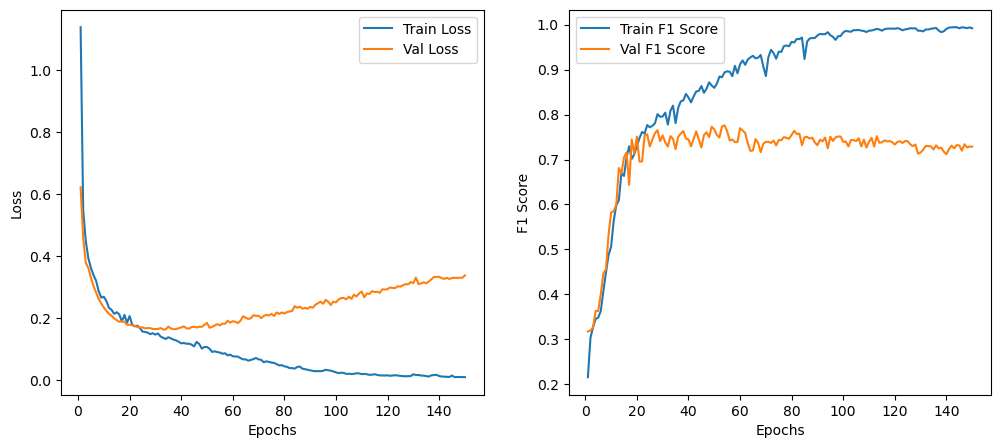

In [12]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()